# Table of Contents

- Setup 
    - Dataset and DataLoader
    - Training loop
    - Model architecture
- Model training
- Model Testing
- General CNN Notes

In [2]:
!pip install -q torch-lr-finder

In [166]:
import torch
from torch import tensor, Tensor
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from utils import display_tensor_as_image, set_optimal_learning_rate

## Setup

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device.type = }')

device.type = 'cpu'


### Dataset and DataLoader

In [167]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True)

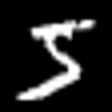

In [4]:
display_tensor_as_image(mnist[0][0])

### Training loop

In [134]:
from typing import Callable

def train_one_epoch(model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> float:
    epoch_running_loss = 0

    for batch in dataloader:
        inputs, labels = batch

        inputs = inputs.to(device) #  move to GPU if available
        labels = labels.to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        predictions = model(inputs)

        # compute loss and propogate gradients
        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        # update metainformation
        epoch_running_loss += loss.item()

    epoch_avg_loss = epoch_running_loss / len(dataloader)
    return epoch_avg_loss


def train_n_epochs(n: int, model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> None:
    for i in range(n):
        epoch_avg_loss = train_one_epoch(model, dataloader, loss_fn, optimizer)
        print(f'epoch {i}: {epoch_avg_loss = }')


### Model architecture

In [151]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network
    '''
    def __init__(self):
        super(CNN, self).__init__()
        in_channels = 1 # grayscale image
        
        conv_1_n_kernels = 6
        conv_1_kernel_size = 5
        conv_1_padding = int((conv_1_kernel_size - 1) / 2) # this is the formula to preserve size assuming a stride of 1

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=conv_1_n_kernels,
                      kernel_size=conv_1_kernel_size,
                      stride=1,
                      padding=conv_1_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # this downsamples the input by factor of 2
        )

        fully_connected_1_in = int(28 /  2) ** 2 # 28*28 gets downsampled to 14*14
        fully_connected_1_out = 100
        self.fully_connected_1 = nn.Sequential(
            nn.Linear(fully_connected_1_in * conv_1_n_kernels, fully_connected_1_out),
            nn.ReLU()
        )

        self.fully_connected_2 = nn.Sequential(
            nn.Linear(fully_connected_1_out, 10),
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = x.flatten(start_dim=1) # [batch_size, 14, 14] => [batch_size, 14*14]
        x = self.fully_connected_1(x)
        x = self.fully_connected_2(x)
        return x



## Model training

In [181]:
cnn = CNN()
cnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=.001, params=cnn.parameters())

# set_optimal_learning_rate(cnn, optimizer, loss_fn, mnist_loader, device, end_lr=.01, num_iter=100)

In [182]:
n_epochs = 15
train_n_epochs(n_epochs, cnn, mnist_loader, loss_fn, optimizer)

epoch 0: epoch_avg_loss = 0.3165370847886877
epoch 1: epoch_avg_loss = 0.10736762019577248
epoch 2: epoch_avg_loss = 0.07240611262994805
epoch 3: epoch_avg_loss = 0.0548827539633479
epoch 4: epoch_avg_loss = 0.04335699439322306
epoch 5: epoch_avg_loss = 0.036311111557654846
epoch 6: epoch_avg_loss = 0.02962964236246559
epoch 7: epoch_avg_loss = 0.02417637694297286
epoch 8: epoch_avg_loss = 0.021054732668959946
epoch 9: epoch_avg_loss = 0.01798543394639726
epoch 10: epoch_avg_loss = 0.015015486319418942
epoch 11: epoch_avg_loss = 0.013329268066780463
epoch 12: epoch_avg_loss = 0.011218645271877988
epoch 13: epoch_avg_loss = 0.008903738465816985
epoch 14: epoch_avg_loss = 0.009002252518585321


## Model Testing

In [169]:
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=True)

In [183]:
cnn.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in mnist_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = cnn(inputs)

        _, predictions = torch.max(logits, 1)

        # predictions.shape = [64]
        # labels.shape = [64]

        total += len(inputs)
        correct += (predictions == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the cnn on the MNIST test images: {accuracy * 100}%')

Accuracy of the cnn on the MNIST test images: 98.64%


## General CNN Notes

### What is the kernel really doing?

In [37]:
torch.manual_seed(3)

kernel = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=1)
print(f'{kernel.weight = }', '\n')

input_data = torch.ones(1, 5, 5)
print(f'{input_data = }', '\n')

kernel.weight = Parameter containing:
tensor([[[[-0.3305, -0.2630, -0.1428],
          [-0.3154, -0.0189, -0.2933],
          [ 0.1812,  0.1625,  0.0629]]]], requires_grad=True) 

input_data = tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]]) 



Let kernel size be `x * x`. 

The kernel slides across the input data, looking at every chunk of size `x * x` in the input data.

For each chunk, the kernel outputs the `sum(element_wise_multiplication(kernel.weight, current_chunk_of_input)) + kernel.bias`

---

This calculation is essentially a unique type of the dot product. It calculates the similarity between the input chunk and the kernel.

The feature map (aka output of kernel), is of the same shape as the input when the padding is correct. Each "pixel" in the feature map represents this calculation against the `current_chunk_of_input` data. Where `current_chunk_of_input` is a piece of the input data, that is the same size as the kernel. The kernel slides across each possible chunk of the size of the kernel in the input (when the stride is 1).

In [39]:
feature_map = kernel(input_data)
print(f'{feature_map = }', '\n')

feature_map = tensor([[[ 0.1718,  0.0377,  0.0377,  0.0377,  0.2680],
         [-0.2339, -0.6985, -0.6985, -0.6985, -0.3255],
         [-0.2339, -0.6985, -0.6985, -0.6985, -0.3255],
         [-0.2339, -0.6985, -0.6985, -0.6985, -0.3255],
         [-0.4593, -1.1052, -1.1052, -1.1052, -0.6692]]],
       grad_fn=<SqueezeBackward1>) 



Here, the top left value of the `feature_map` is `.01718` (from `feature_map[0][0]`).

That means that the dot product like calculation of `sum(element_wise_multiplication(kernel.weight, current_chunk_of_input)) + kernel.bias` for the `first_chunk_of_input` and `kernel` should be `.01718`. Let's verify that.


In [72]:
import torch.nn.functional as F

first_chunk_of_input = input_data[:2, :2, :2] # the top left chunk of the input_data. because our kernel uses padding, we need to pad this with 0's.
print(f'{first_chunk_of_input = }', '\n')

# pad tuple: (left, right, top, bottom)
first_chunk_of_input = F.pad(first_chunk_of_input, (1, 0, 1, 0), 'constant', 0)
print(f'padded {first_chunk_of_input = }', '\n')

first_chunk_of_input = tensor([[[1., 1.],
         [1., 1.]]]) 

padded first_chunk_of_input = tensor([[[0., 0., 0.],
         [0., 1., 1.],
         [0., 1., 1.]]]) 



In [75]:
element_wise_mulitplication = kernel.weight * first_chunk_of_input
print(f'{element_wise_mulitplication = }', '\n')

output = element_wise_mulitplication.sum() + kernel.bias
print(f'{output = }', '\n')

element_wise_mulitplication = tensor([[[[-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0189, -0.2933],
          [ 0.0000,  0.1625,  0.0629]]]], grad_fn=<MulBackward0>) 

output = tensor([0.1718], grad_fn=<AddBackward0>) 



They match!